In [4]:
pd.set_option('display.max_rows',None)

In [4]:
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dateutil.relativedelta import relativedelta, TH ,WE , TU
from dateparser import parse
import os
import re
import concurrent.futures

In [22]:
# user inputs
ce_strike_from_atm = 0
pe_strike_from_atm = 0
slpercentage = 13
user_input = {'ce_reentry':2,'pe_reentry':2}
entry_h = '09'
entry_m = '20'
exit_h = '15'
exit_m = '20'
maxloss = -500
startdate = "2022-01-03" # available dates: "2018-04-20" to "2021-04-22" and '2022-01-03' to '2022-12-01'
enddate = "2022-11-24"


In [23]:
# creating df with each expiry csv filename to access csv for particular expiry
path = pd.DataFrame()
for i in range(2018,2023,1):
    df_path = pd.DataFrame(glob(f'banknifty fno/{i}/*'),columns=['location'])
    df_path['expiry'] = df_path['location'].apply(lambda x: x.split('\\')[-1])
    df_path['expiry'] = df_path['expiry'].str.replace(r'Expiry ', '')
    df_path['expiry'] = df_path['expiry'] + f' {i}'
    df_path['expiry'] = pd.to_datetime(df_path['expiry'])
    df_path.set_index('expiry',inplace=True)
    path = pd.concat([path,df_path])
    path.sort_values(by='expiry',inplace=True)
path

,location
expiry,
2018-04-26,banknifty fno/2018\Expiry 26th April
2018-05-03,banknifty fno/2018\Expiry 03rd May
2018-05-10,banknifty fno/2018\Expiry 10th May
2018-05-17,banknifty fno/2018\Expiry 17th May
2018-05-24,banknifty fno/2018\Expiry 24th May
...,...
2022-11-24,banknifty fno/2022\Expiry 24th November
2022-12-01,banknifty fno/2022\Expiry 01st December
2022-12-08,banknifty fno/2022\Expiry 8th December


In [24]:
# fetching bnf spot csv file to get the dates for backtest
bnf_df = pd.DataFrame()
for i in range(2018,2023,1):
    peryear_bnf_df = pd.read_csv(f'banknifty spot/{i}.csv',names=['instrument','date','time','open','high','low','close','volume','oi'])
    bnf_df = pd.concat([bnf_df,peryear_bnf_df])

bnf_df['date'] = pd.to_datetime(bnf_df['date'])
dates_available = bnf_df.drop_duplicates(subset='date').reset_index(drop=True)['date']

# dates to backtest
start_date = datetime.strptime(startdate,'%Y-%m-%d')
end_date = datetime.strptime(enddate,'%Y-%m-%d')
dates_to_bt = dates_available[dates_available.between(start_date,end_date)]
dates_to_bt



989    2022-01-03
990    2022-01-04
991    2022-01-05
992    2022-01-06
993    2022-01-07
          ...    
1206   2022-11-18
1207   2022-11-21
1208   2022-11-22
1209   2022-11-23
1210   2022-11-24
Name: date, Length: 222, dtype: datetime64[ns]

In [25]:
def backtest(date,user_input):
    pe_reentry,ce_reentry = user_input['ce_reentry'], user_input['pe_reentry']
    for i in range(1):
        
        # fetch atm
        try:
            spot = bnf_df[(bnf_df['date'] == date) & (bnf_df['time'] == f'{entry_h}:{entry_m}')]['open'].iloc[0]
            atm = 100 * round(spot/100)
            ce_atm = atm + ce_strike_from_atm
            pe_atm = atm - pe_strike_from_atm
        except:
            continue
            
        # fetch nearest expiry to date
        try:
            nearest_expiry = date.date() + relativedelta(weekday=TH(+1))
            nearest_expiry = nearest_expiry.strftime("%Y-%m-%d")
            data = pd.DataFrame(glob(f"{path.loc[nearest_expiry][0]}\*"),columns=['csv files'])
        except:
            try:
                nearest_expiry = date.date() + relativedelta(weekday=WE(+1))
                nearest_expiry = nearest_expiry.strftime("%Y-%m-%d")
                data = pd.DataFrame(glob(f"{path.loc[nearest_expiry][0]}\*"),columns=['csv files'])
            except:
                try:
                    nearest_expiry = date.date() + relativedelta(weekday=TU(+1))
                    nearest_expiry = nearest_expiry.strftime("%Y-%m-%d")
                    data = pd.DataFrame(glob(f"{path.loc[nearest_expiry][0]}\*"),columns=['csv files'])
                except:
                    print('data invalid/not found or foldername invalid : ',nearest_expiry)
                    print()
                    continue


        # fetch stike name from csv filename and fetch atm strike csv file
        ce = str(ce_atm)+'CE'
        pe = str(pe_atm)+'PE'
        data['strike'] = data['csv files'].apply(lambda x: x.split('\\')[-1][-11:-4])        
        filt_data = data[(data['strike'] == ce) | (data['strike'] == pe)]

        if filt_data.empty:
            ce = 'CE ' + str(ce_atm)
            pe = 'PE ' + str(pe_atm)
            data['strike'] = data['csv files'].apply(lambda x: x.split('\\')[-1][:-4])
            filt_data = data[(data['strike'] == ce) | (data['strike'] == pe)]

        try:
            ce_csv = pd.read_csv(filt_data.iloc[0][0],names=['instrument','date','time','open','high','low','close','volume','oi'])
            pe_csv = pd.read_csv(filt_data.iloc[1][0],names=['instrument','date','time','open','high','low','close','volume','oi'])
            ce_symbol = ce_csv['instrument'].iloc[0]
            pe_symbol = pe_csv['instrument'].iloc[0]
        except:
            continue

        # merging date & time and setting it as index
        # for pe
        pe_csv['time'] = pe_csv['time'].astype(str) + ':00'
        pe_csv['date'] = pe_csv['date'].astype(str)
        pe_csv['date'] = pd.to_datetime(pe_csv['date'] +' '+ pe_csv['time'])
        pe_csv.pop('time')
        pe_csv.rename(columns={'date':'datetime'},inplace=True)
        pe_csv.set_index('datetime',inplace=True)
        # for ce
        ce_csv['time'] = ce_csv['time'].astype(str) + ':00'
        ce_csv['date'] = ce_csv['date'].astype(str)
        ce_csv['date'] = pd.to_datetime(ce_csv['date'] +' '+ ce_csv['time'])
        ce_csv.pop('time')
        ce_csv.rename(columns={'date':'datetime'},inplace=True)
        ce_csv.set_index('datetime',inplace=True)
        ce_csv = ce_csv[ce_csv.index.duplicated() == False]
        pe_csv = pe_csv[pe_csv.index.duplicated() == False]
        
        # concat both df and selecting range to bt
        intraday_data = pd.concat([ce_csv,pe_csv],axis=1)
        entry_datetime = datetime.combine(date,time(int(entry_h),int(entry_m)))
        exit_datetime = datetime.combine(date,time(int(exit_h),int(exit_m)))
        try:
            entry_time_index = intraday_data[intraday_data.index == entry_datetime].index[0]
            exit_time_index = intraday_data[intraday_data.index == exit_datetime].index[0]
        except IndexError:
            print('entry/exit time in invalid/not found')
            continue
        intraday_data = intraday_data[entry_time_index:exit_time_index]
        intraday_data.ffill(axis = 0,inplace=True)

        try:
            intraday_data.columns = ['ce_instru', 'ce_open', 'ce_high', 'ce_low', 'ce_close', 'ce_volume', 'ce_oi',
                                    'pe_instru', 'pe_open', 'pe_high', 'pe_low', 'pe_close', 'pe_volume', 'pe_oi']
        except:
            try:
                intraday_data.columns = ['ce_instru', 'ce_open', 'ce_high', 'ce_low', 'ce_close', 'ce_volume',
                                    'pe_instru', 'pe_open', 'pe_high', 'pe_low', 'pe_close', 'pe_volume']
            except Exception as e:
                print(e)


        intraday_data = intraday_data[['ce_instru', 'ce_open', 'ce_high', 'ce_low', 'ce_close',
                                    'pe_instru', 'pe_open', 'pe_high', 'pe_low', 'pe_close']]

        # defaults
        intraday_data['ce_pnl'] = 0
        intraday_data['pe_pnl'] = 0
        ce_entry = intraday_data['ce_open'].iloc[0]
        pe_entry = intraday_data['pe_open'].iloc[0]
        sl = (slpercentage + 100) / 100
        ce_sl = ce_entry * sl
        pe_sl = pe_entry * sl
        pnl = 0
        ce_exist = True
        pe_exist = True
        ce_loss = 0
        pe_loss = 0
        
        # reentry strategy
        for index, row in intraday_data.iterrows():  
            if ce_exist:
                if row['ce_high'] > ce_sl:
                    ce_pnl = (ce_entry - ce_sl) + ce_loss
                    ce_exist = False
                    ce_loss = ce_pnl
                else:
                    ce_pnl = (ce_entry - row['ce_close']) + ce_loss

            elif ce_exist == False and row['ce_open'] < ce_entry and ce_reentry != 0:
                ce_entry = row['ce_open']
                ce_sl = ce_entry * sl
                ce_exist = True
                ce_reentry -= 1
                
            if pe_exist:
                if row['pe_high'] > pe_sl:
                    pe_pnl = (pe_entry - pe_sl) + pe_loss
                    pe_exist = False
                    pe_loss = pe_pnl
                else:
                    pe_pnl = (pe_entry - row['pe_close']) + pe_loss

            elif pe_exist == False and row['pe_open'] < pe_entry and pe_reentry != 0:
                pe_entry = row['pe_open']
                pe_sl = pe_entry * sl
                pe_exist = True
                pe_reentry -= 1

            intraday_data.loc[index,'ce_pnl'] = ce_pnl * 25
            intraday_data.loc[index,'pe_pnl'] = pe_pnl * 25
            pnl = (ce_pnl + pe_pnl) * 25

            if pnl <= maxloss:
                pnl = maxloss
                break

        log = pd.DataFrame({'Entry_Datetime':[entry_datetime],
                            'spot':[spot],
                            'ATM':[atm],
                            'CE_ATM':[ce_atm],
                            'PE_ATM':[pe_atm],
                            'CE_Symbol':[ce_symbol],
                            'PE_Symbol':[pe_symbol],
                            'PnL':[pnl]})
        return log

In [27]:
# run without concurrency
intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','spot','ATM','CE_Symbol','PE_Symbol','PnL'])
start = datetime.now()
for date in dates_to_bt:
    log = backtest(date,user_input)
    intraday_trade_log = pd.concat([intraday_trade_log, log])
# intraday_trade_log.reset_index(inplace=True,drop = True)
intraday_trade_log = intraday_trade_log.reset_index(drop=True)
intraday_trade_log
end = datetime.now()
print(end - start)

0:00:44.474677


In [28]:
intraday_trade_log

,Entry_Datetime,spot,ATM,CE_Symbol,PE_Symbol,PnL,CE_ATM,PE_ATM
0,2022-01-03 09:20:00,35689.05,35700,BANKNIFTYWK35700CE,BANKNIFTYWK35700PE,-500,35700.0,35700.0
1,2022-01-04 09:20:00,36532.7,36500,BANKNIFTYWK36500CE,BANKNIFTYWK36500PE,-500,36500.0,36500.0
2,2022-01-05 09:20:00,37063.45,37100,BANKNIFTYWK37100CE,BANKNIFTYWK37100PE,-500,37100.0,37100.0
3,2022-01-06 09:20:00,37243.8,37200,BANKNIFTYWK37200CE,BANKNIFTYWK37200PE,-500,37200.0,37200.0
4,2022-01-07 09:20:00,37809.95,37800,BANKNIFTYWK37800CE,BANKNIFTYWK37800PE,-500,37800.0,37800.0
...,...,...,...,...,...,...,...,...
216,2022-11-18 09:20:00,42484.4,42500,BANKNIFTY42500CE,BANKNIFTY42500PE,154.7375,42500.0,42500.0
217,2022-11-21 09:20:00,42321.7,42300,BANKNIFTY42300CE,BANKNIFTY42300PE,-500,42300.0,42300.0
218,2022-11-22 09:20:00,42415.2,42400,BANKNIFTY42400CE,BANKNIFTY42400PE,1445.0,42400.0,42400.0
219,2022-11-23 09:20:00,42620.05,42600,BANKNIFTY42600CE,BANKNIFTY42600PE,754.0875,42600.0,42600.0


In [29]:
# # run without concurrency
# intraday_trade_log = pd.DataFrame(columns=['Entry_Datetime','spot','ATM','CE_Symbol','PE_Symbol','PnL'])
# start = datetime.now()
# def main():
#     global intraday_trade_log
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         result = executor.map(backtest, dates_to_bt)
#         for log in result:
#             intraday_trade_log = pd.concat([intraday_trade_log, log])
#     display(intraday_trade_log)
# if __name__ == '__main__':
#     main()
# end = datetime.now()
# print(end - start)

C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Equity'].iloc[i] = initial_capital + intraday_trade_log['PnL'].iloc[i]
C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Rate_of_Return'].iloc[i] = (intraday_trade_log['PnL'].iloc[i]/initial_capital)*100
C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

Win Rate: 30.0 %
Expectancy:0.99
Max Drawdown [Rs.] :-6709.12
Max Drawdown Percent:-2.79


C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Recovery'].iloc[i] = intraday_trade_log['Recovery'].iloc[i-1] + 1


Number of trades done from Drawdown to achieve a new peak: 30
CAGR:62.29
Number of Wins: 66
Number of Losses: 155
Average Profit Per Trade: 2801.97
Average Loss Per Trade: -497.63
Max PnL Point:8825.26
Min PnL Point:-500


C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Continuous_Losses'].iloc[i] = intraday_trade_log['Continuous_Losses'].iloc[i-1]+1
C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_trade_log['Continuous_Wins'].iloc[i] = intraday_trade_log['Continuous_Wins'].iloc[i-1]+1


maximum Consecutive Wins:3
maximum Consecutive Losses:10
0:00:07.960574


C:\Users\nishad\AppData\Local\Temp\ipykernel_6824\1119979282.py:103: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({'overall profit':overall_profit,


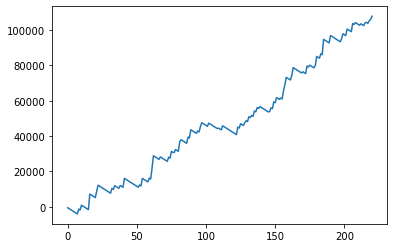

In [30]:
start = datetime.now()

# metrices    
intraday_trade_log = intraday_trade_log.reset_index(drop=True)
intraday_trade_log['PnL'].cumsum().plot()

intraday_trade_log['PnL_cumsum'] = intraday_trade_log['PnL'].cumsum()

initial_capital = 200000
intraday_trade_log['Equity'] = 0
intraday_trade_log['Rate_of_Return'] = 0

for i in range(len(list(intraday_trade_log.index))):

    if i == 0:
        intraday_trade_log['Equity'].iloc[i] = initial_capital + intraday_trade_log['PnL'].iloc[i]
        intraday_trade_log['Rate_of_Return'].iloc[i] = (intraday_trade_log['PnL'].iloc[i]/initial_capital)*100
    else:
        intraday_trade_log['Equity'].iloc[i] = intraday_trade_log['Equity'].iloc[i-1] + intraday_trade_log['PnL'].iloc[i]
        intraday_trade_log['Rate_of_Return'].iloc[i] = (intraday_trade_log['PnL'].iloc[i]/intraday_trade_log['Equity'].iloc[i-1])*100

intraday_trade_log

number_of_trades = len(intraday_trade_log)
number_of_trades

win_rate = round(len(intraday_trade_log[intraday_trade_log['PnL']>0])/len(intraday_trade_log),2)
win_rate_percent = win_rate * 100
print(f'Win Rate: {win_rate_percent} %')

mean_win = intraday_trade_log[intraday_trade_log['PnL']>0]['PnL'].mean()
mean_loss = intraday_trade_log[intraday_trade_log['PnL']<0]['PnL'].mean()
risk_reward = abs(mean_win/mean_loss)
expectancy = round((win_rate*risk_reward) - ((1-win_rate)*1),2)

print(f'Expectancy:{expectancy}')

intraday_trade_log['Drawdown'] = intraday_trade_log['PnL_cumsum'] - intraday_trade_log['PnL_cumsum'].cummax()
max_drawdown = round(intraday_trade_log['Drawdown'].min(),2)
print(f'Max Drawdown [Rs.] :{max_drawdown}')

max_drawdown_percent = round(max_drawdown/intraday_trade_log[intraday_trade_log['Drawdown'] == intraday_trade_log['Drawdown'].min()]['Equity'].iloc[0]*100,2)
print(f'Max Drawdown Percent:{max_drawdown_percent}')

intraday_trade_log['Recovery'] = 0
for i in range(len(intraday_trade_log)):
    if (intraday_trade_log['Drawdown'].iloc[i] < 0):
        intraday_trade_log['Recovery'].iloc[i] = intraday_trade_log['Recovery'].iloc[i-1] + 1
recovery_trades = intraday_trade_log['Recovery'].max()

print(f'Number of trades done from Drawdown to achieve a new peak: {recovery_trades}')

# intraday_trade_log_equity_high = intraday_trade_log[intraday_trade_log['Recovery'] == 0]
# intraday_trade_log_equity_high['number_days_between_equity_highs'] = (intraday_trade_log_equity_high['Entry_Datetime'] - intraday_trade_log_equity_high['Entry_Datetime'].shift())
# # intraday_trade_log_equity_high['number_days_between_equity_highs'] = intraday_trade_log_equity_high['number_days_between_equity_highs'].fillna(0)
# recovery_days = int(intraday_trade_log_equity_high['number_days_between_equity_highs'].apply(lambda x: x.days).max())
# print(f'Number of Days taken from Drawdown to achieve a new peak: {recovery_days}')
recovery_days = 0

number_of_trading_days_for_this_backtest = (intraday_trade_log.iloc[-1]['Entry_Datetime'].date() - intraday_trade_log.iloc[0]['Entry_Datetime'].date()).days
cagr = (((intraday_trade_log.iloc[-1]['Equity']/initial_capital)**(1/(number_of_trading_days_for_this_backtest/365)))-1)*100
cagr = round(cagr,2)

print(f'CAGR:{cagr}')

number_of_wins = len(intraday_trade_log[intraday_trade_log['PnL']>0])
print(f'Number of Wins: {number_of_wins}')

number_of_losses = len(intraday_trade_log[intraday_trade_log['PnL']<0])
print(f'Number of Losses: {number_of_losses}')

average_profit_per_trade = round(intraday_trade_log[intraday_trade_log['PnL'] > 0]['PnL'].mean(),2)
print(f'Average Profit Per Trade: {average_profit_per_trade}')

average_loss_per_trade = round(intraday_trade_log[intraday_trade_log['PnL'] < 0]['PnL'].mean(),2)
print(f'Average Loss Per Trade: {average_loss_per_trade}')

max_pnl = round(intraday_trade_log['PnL'].max(),2)
print(f'Max PnL Point:{max_pnl}')

min_pnl = round(intraday_trade_log['PnL'].min(),2)
print(f'Min PnL Point:{min_pnl}')

intraday_trade_log['Continuous_Wins'] = 0
intraday_trade_log['Continuous_Losses'] = 0

for i in range(1,len(intraday_trade_log)):
    if intraday_trade_log['PnL'].iloc[i-1] > 0:
        intraday_trade_log['Continuous_Wins'].iloc[i] = intraday_trade_log['Continuous_Wins'].iloc[i-1]+1
    if intraday_trade_log['PnL'].iloc[i-1] < 0:
        intraday_trade_log['Continuous_Losses'].iloc[i] = intraday_trade_log['Continuous_Losses'].iloc[i-1]+1

consecutive_wins = intraday_trade_log['Continuous_Wins'].max()
consecutive_losses = intraday_trade_log['Continuous_Losses'].max()
print(f'maximum Consecutive Wins:{consecutive_wins}')
print(f'maximum Consecutive Losses:{consecutive_losses}')

overall_profit = intraday_trade_log['PnL'].sum()

metrics = pd.DataFrame(columns=['overall profit','Number of Trades','Number of Wins','Number of Losses','Average Profit','Average Loss','Maximum Profit Points','Maximum Loss Points','Win Rate','Expectancy','Max Drawdown','Max Drawdown Percent','Days Taken to Recover From Drawdown','Number of Trades to Recover From Drawdown','CAGR','Consecutive Wins','Consecutive Losses'])


metrics = metrics.append({'overall profit':overall_profit,
                          'Number of Trades':number_of_trades,
                          'Number of Wins':number_of_wins,
                          'Number of Losses':number_of_losses,
                          'Average Profit':average_profit_per_trade,
                          'Average Loss':average_loss_per_trade,
                          'Maximum Profit Points':max_pnl,
                          'Maximum Loss Points':min_pnl,
                          'Win Rate':win_rate,
                          'Expectancy':expectancy,
                          'Max Drawdown':max_drawdown,
                          'Max Drawdown Percent':max_drawdown_percent,
                          'Days Taken to Recover From Drawdown':recovery_days,
                          'Number of Trades to Recover From Drawdown':recovery_trades,
                          'CAGR':cagr,
                          'Consecutive Wins':consecutive_wins,
                          'Consecutive Losses':consecutive_losses},ignore_index=True)

metrics.T

end = datetime.now()
print(end - start)


In [10]:
intraday_trade_log['PnL'].sum()

58108.81250000001